In [1]:
import spec
import jax.numpy as jnp
from ark.cdg.cdg import CDG
from ark.ark import Ark
import matplotlib.pyplot as plt
import numpy as np


In [55]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


import matplotlib as mpl
# Use latex for text rendering
plt.rc('text', usetex=True)
plt.rc('font', family='sans-serif')

# Large text and labels
plt.rcParams.update({'font.size': 20})

# bold text
plt.rcParams.update({'font.weight': 'bold'})

# axes tick size
plt.rcParams.update({'axes.labelsize': 25})
plt.rcParams.update({'axes.titlesize': 30})
# tick size
plt.rcParams.update({'xtick.labelsize': 25})
plt.rcParams.update({'ytick.labelsize': 25})

# set tick and label bold


text_in_fig_size = 25

# Use a custom color order
colors = [
    '#d62728',  # red
    '#1f77b4',  # blue
    '#2ca02c',  # green
    '#ff7f0e',  # orange
    '#9467bd',  # purple
    '#8c564b',  # brown
    '#e377c2',  # pink
    '#7f7f7f',  # gray
    '#bcbd22',  # yellow-green
    '#17becf'   # cyan
]


n_sections_for_one_third_period: 8
n_sections_for_half_period: 12


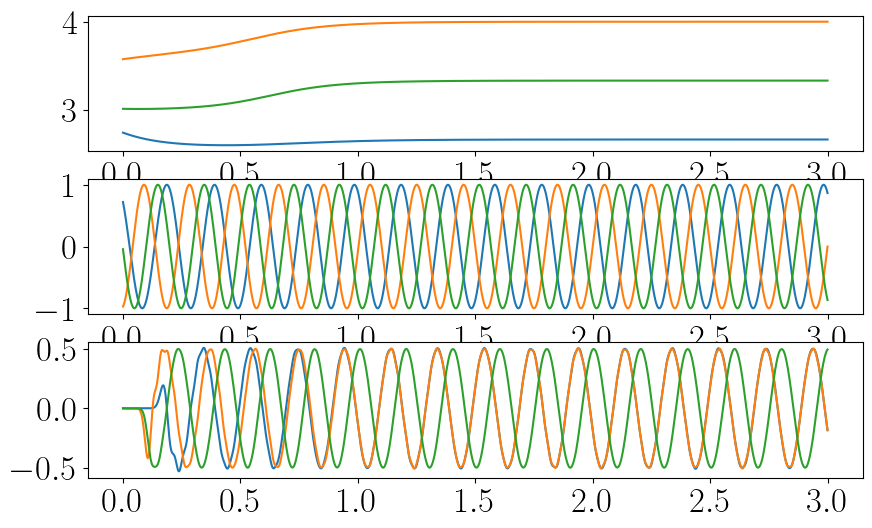

In [56]:
# Test osc2v conversion
np.random.seed(0)
def locking_fn(x, lock_strength: float):
    "Injection locking function with phase normalize from pi to 1"
    return lock_strength * jnp.sin(3 * np.pi * x)


def coupling_fn(x, cpl_strength: float):
    "Oscillator coupling function with phase normalize from pi to 1"
    return cpl_strength * jnp.sin(np.pi * x)

def sin_fn(x):
    "Sine function with phase normalize from pi to 1"
    return jnp.sin(x)

def mk_lines(graph: CDG, length: int, lc_val: float):
    "Make a line of LC elements with matched load impedance"
    lcs = [spec.IdealV(c=lc_val, g=1)]
    graph.connect(spec.IdealE(), lcs[0], lcs[0])
    prev_c = lcs[0]
    for i in range(length):
        ind, cap = spec.IdealI(l=lc_val, r=0), spec.IdealV(c=lc_val, g=0)
        lcs.extend([ind, cap])
        graph.connect(spec.IdealE(), prev_c, ind)
        graph.connect(spec.IdealE(), ind, cap)
        prev_c = cap
        # Omit the self connection because g and r are set to 0 anyway
    prev_c.attrs["g"] = 1
    graph.connect(spec.IdealE(), prev_c, prev_c)
    for ele in lcs:
        ele.set_init_val(val=0, n=0)
    return lcs

graph = CDG()
time_points = jnp.linspace(0, 3, 10000)
node_attrs = {
    "lock_fn": locking_fn,
    "osc_fn": coupling_fn,
    "lock_strength": 0.5,
    "cpl_strength": 0.5,
}
n_oscs = 3
wave_freq = 5
one_period = 1 / wave_freq

base_n_sections = 10
lc_val = 1 / 24 / wave_freq
tline_velocity = 1 / lc_val
one_section_time = 1 / tline_velocity
assert int(one_period) // (one_section_time * 3) == 0, "One period should be divisible by three sections"
assert int(one_period) // (one_section_time * 2) == 0, "One period should be divisible by two sections"
n_sections_for_one_third_period = int(one_period / one_section_time / 3)
n_sections_for_half_period = int(one_period / one_section_time / 2)
print(f"n_sections_for_one_third_period: {n_sections_for_one_third_period}")
print(f"n_sections_for_half_period: {n_sections_for_half_period}")

oscs = [spec.Osc(**node_attrs) for _ in range(n_oscs)]
lcss = [mk_lines(graph, length=base_n_sections + n_sections_for_one_third_period, lc_val=lc_val)] + [mk_lines(graph, length=base_n_sections, lc_val=lc_val) for _ in range(n_oscs - 1)]

init_phases_normalized = np.random.rand(n_oscs) * 5
for i, (osc, lcs) in enumerate(zip(oscs, lcss)):
    graph.connect(spec.Coupling(k=-1.0), osc, oscs[(i + 1) % n_oscs])   
    graph.connect(spec.Coupling(k=1.0), osc, osc)
    osc.set_init_val(init_phases_normalized[i], n=0)

    p2v_edge = spec.Phase2VoltE(
        f=wave_freq,
        sin=sin_fn,
    )
    graph.connect(p2v_edge, osc, lcs[0])




system = Ark(cdg_spec=spec.obc_tln_spec)
system.compile(cdg=graph)
system.execute(cdg=graph, time_eval=time_points)
fig, axes = plt.subplots(3, 1, figsize=(10, 6))
for i, osc in enumerate(oscs):
    traj = osc.get_trace(n=0)
    axes[0].plot(time_points, traj, label=f"Oscillator {i}")
    axes[1].plot(time_points, np.sin(2 * np.pi * wave_freq * time_points + np.pi * traj))

for i, lcs in enumerate(lcss):
    traj = lcs[-1].get_trace(n=0)
    axes[2].plot(time_points, traj, label=f"Voltage {i}")



In [97]:
# Example: Computing phase difference of 2 oscillator vectors
n_vec = 2
vec_len = 3
time_points = jnp.linspace(0, 1.5, 5000)
p2v_edge_attrs = {
    "f": wave_freq,
    "sin": sin_fn,
}

rectify_edge_attrs = {
    "abs": lambda x: np.where(x > 0, x, 0),
}

def sim_osc_tln(init_phases_normalized: np.ndarray, readout_pos: int, save_file=""):
    """Simulate the oscillator with a transmission line and readout

    2 oscillator vectors with 3 oscillators each. Each pair of oscillators are connected
    with a transmission line of 20 sections. The readout is done at specific sections of the
    transmission line.
    - 0: Compare the first vector with the second vector delayed by 1/3 period
    - 1: Compare the first vector with the second vector
    - 2: Compare the first vector with the second vector advanced by 1/3 period
    """
    graph = CDG()
    oscs = [[spec.Osc(**node_attrs) for _ in range(vec_len)] for _ in range(n_vec)]

    for i in range(n_vec):
        for j in range(vec_len):
            # graph.connect(spec.Coupling(k=-1.0), oscs[i][j], oscs[i][(j + 1) % vec_len])
            graph.connect(spec.Coupling(k=1.0), oscs[i][j], oscs[i][j])
            init_val = init_phases_normalized[i, j]
            oscs[i][j].set_init_val(init_val, n=0)

    # Connect the oscillator in the two vectors with 30 lc sections
    n_line_lc = 20
    tlines = [mk_lines(graph, length=n_line_lc, lc_val=lc_val) for _ in range(vec_len)]
    for i, line in enumerate(tlines):
        graph.connect(spec.Phase2VoltE(**p2v_edge_attrs), oscs[0][i], line[0])
        graph.connect(spec.Phase2VoltE(**p2v_edge_attrs), oscs[1][i], line[-1])
    # graph.visualize()

    n_readout_lc = 4
    readout_idxs = [n_line_lc - n_sections_for_one_third_period - n_sections_for_half_period,
                    n_line_lc - n_sections_for_half_period,
                    n_line_lc + n_sections_for_one_third_period - n_sections_for_half_period]
    readout_lines = [mk_lines(graph, length=n_readout_lc, lc_val=lc_val) for _ in readout_idxs]
    for i, idx in enumerate(readout_idxs):
        for line in tlines:
            graph.connect(spec.RectifyE(**rectify_edge_attrs), line[idx], readout_lines[i][0])

    system = Ark(cdg_spec=spec.obc_tln_spec)
    system.compile(cdg=graph)
    system.execute(cdg=graph, time_eval=time_points)
    figsize = (8, 5)
    for ele_id in range(vec_len):
        fig, ax = plt.subplots(1, 1, figsize=figsize)
        for vec_id in range(n_vec):
            prefix = "A" if vec_id == 0 else "B"
            label = f"{prefix}{ele_id}"
            osc = oscs[vec_id][ele_id]
            traj = osc.get_trace(n=0)
            ax.plot(time_points, np.sin(2 * np.pi * wave_freq * time_points + np.pi * traj), label=label)
            

        # put legend on the top outside the plot
        ax.set_xlabel("Time")
        ax.set_ylabel("Voltage")
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.3), ncol=2, frameon=True)
        plt.tight_layout()
        plt.savefig(f"{save_file}_A{ele_id}B{ele_id}_voltage.pdf", bbox_inches='tight')
        plt.show()
        plt.close()

        fig, ax = plt.subplots(1, 1, figsize=figsize)
        for vec_id in range(n_vec):
            prefix = "A" if vec_id == 0 else "B"
            label = f"{prefix}{ele_id}"
            osc = oscs[vec_id][ele_id]
            traj = osc.get_trace(n=0)
            ax.plot(time_points, traj * np.pi, label=label)
            

        # put legend on the top outside the plot
        ax.set_xlabel("Time")
        ax.set_ylabel("Phase (radiant)")
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.3), ncol=2, frameon=True)
        plt.tight_layout()
        plt.savefig(f"{save_file}_A{ele_id}B{ele_id}_phase.pdf", bbox_inches='tight')
        plt.show()
        plt.close()
        

    # Plot readout on the final axis
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    readout_traj = readout_lines[readout_pos][-1].get_trace(n=0)
    ax.plot(time_points, readout_traj)
    ax.set_xlabel("Time")
    ax.set_ylabel("Voltage")
    ax.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig(f"{save_file}_readout.pdf", bbox_inches='tight')
    plt.show()
    plt.close()



    # Shared y-axis label
    fig.text(0.0, 0.5, "Voltage", va='center', rotation='vertical', fontsize=30)


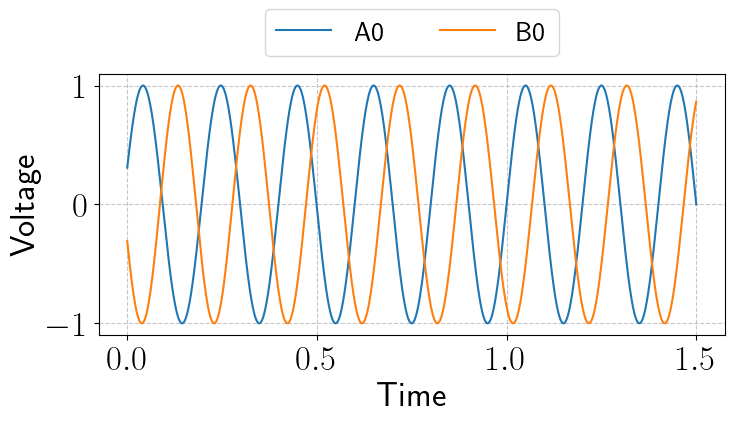

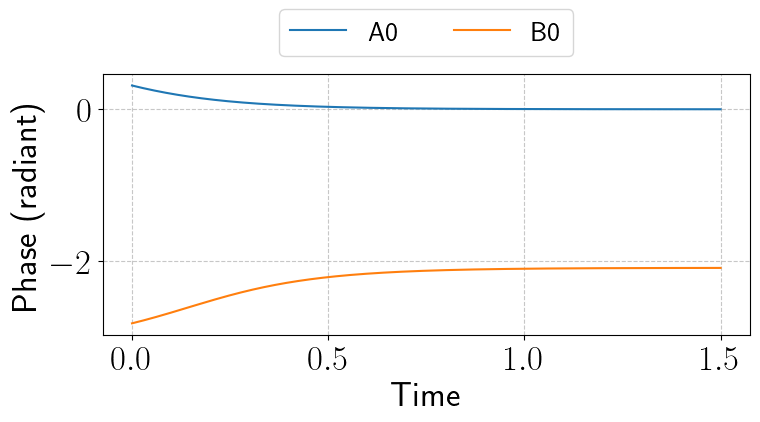

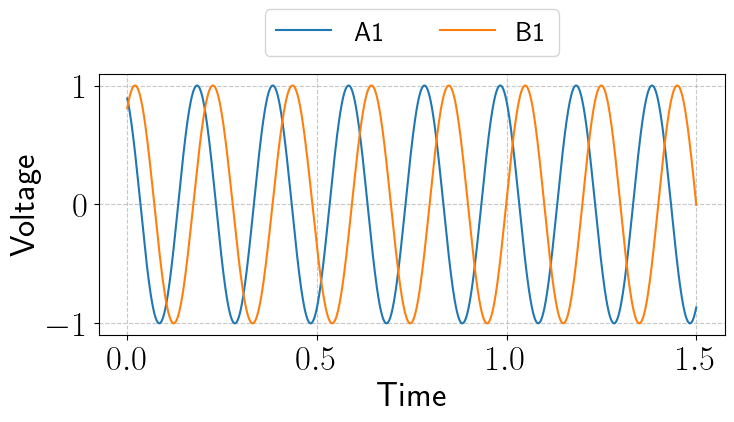

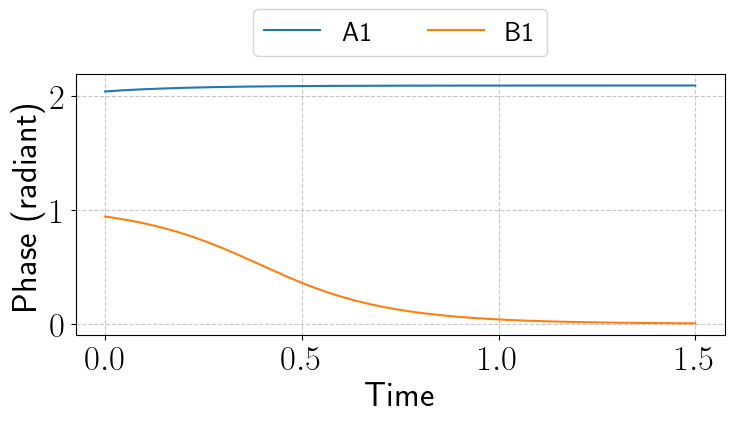

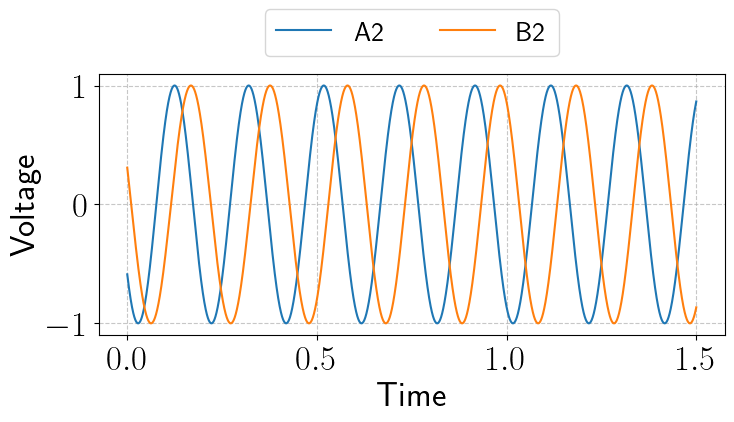

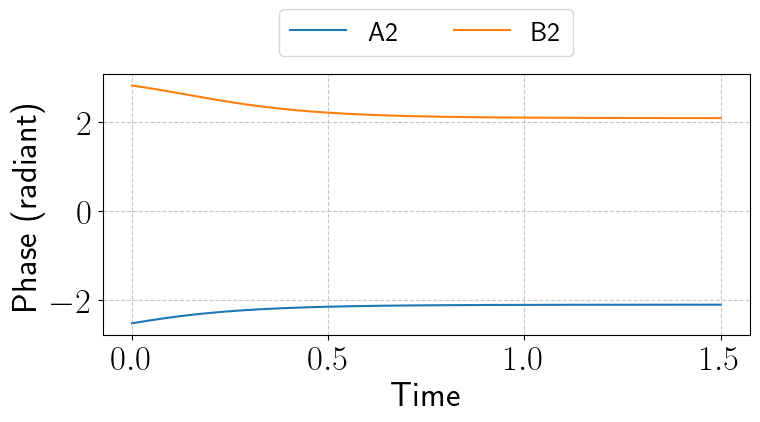

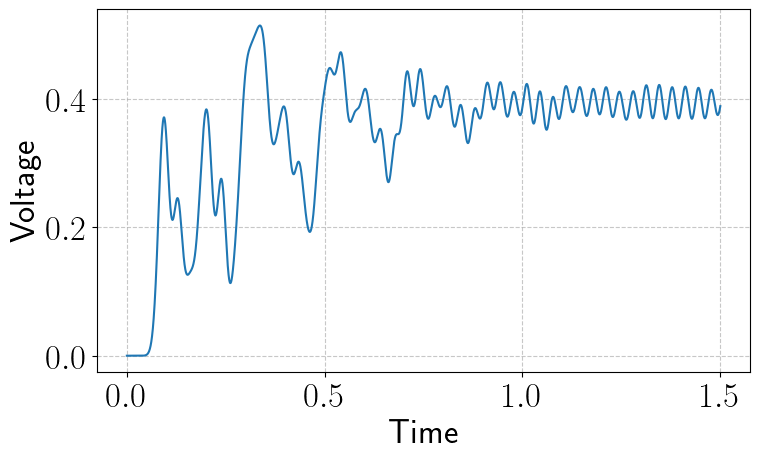

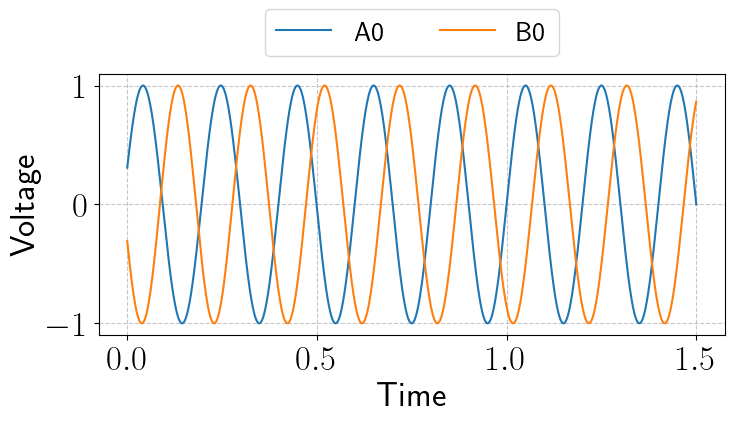

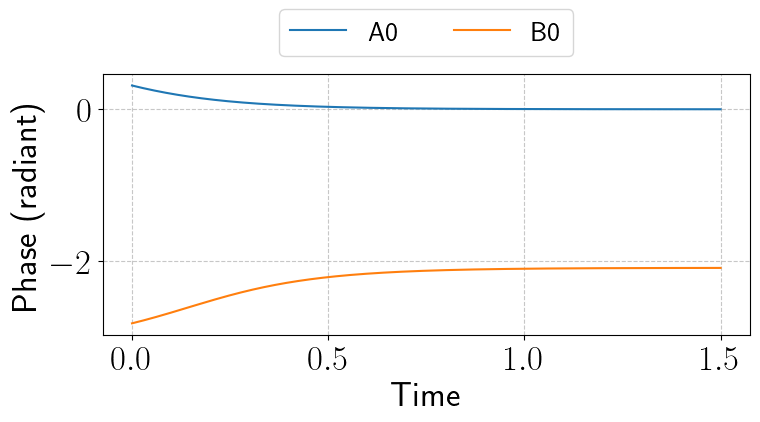

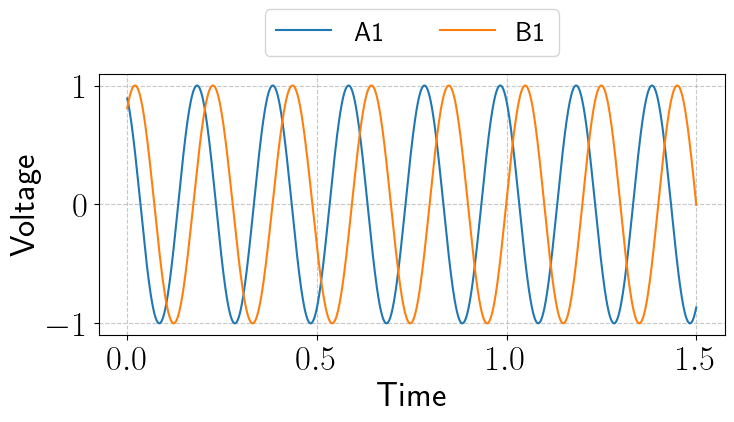

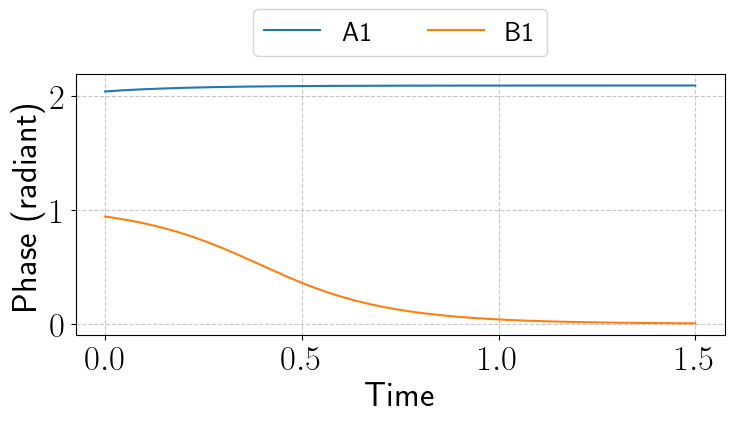

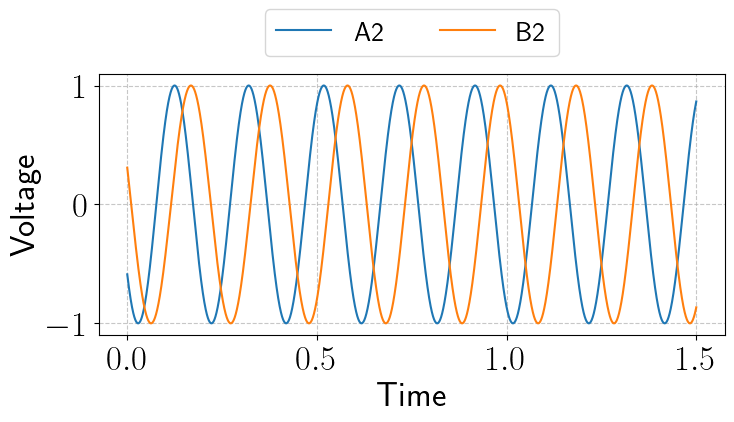

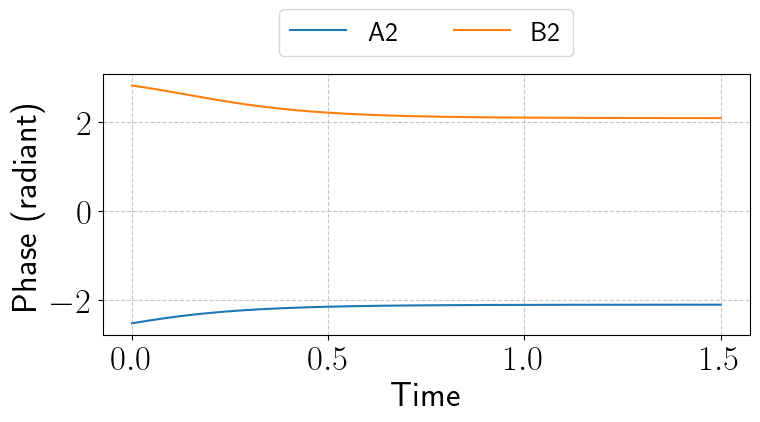

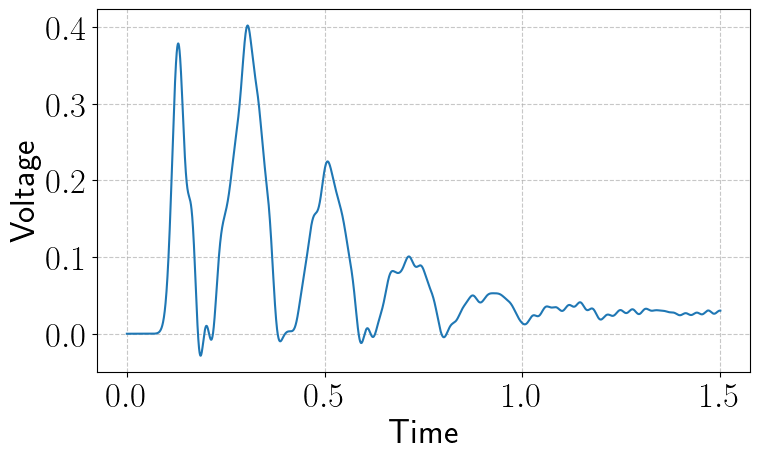

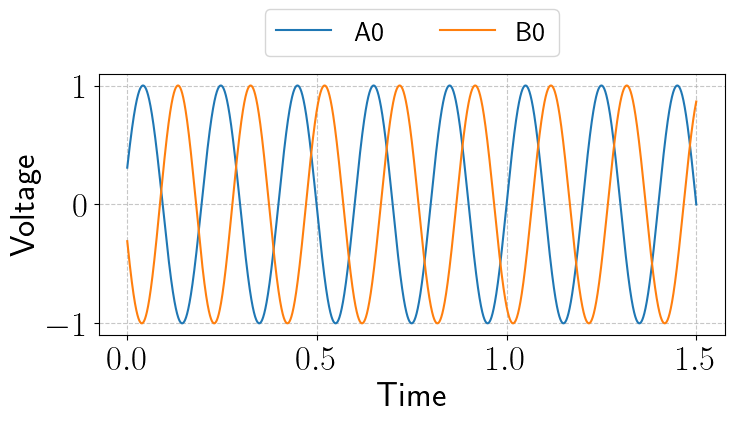

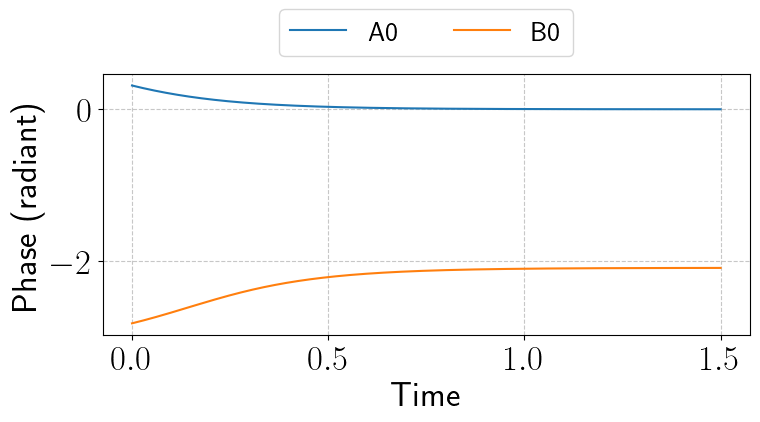

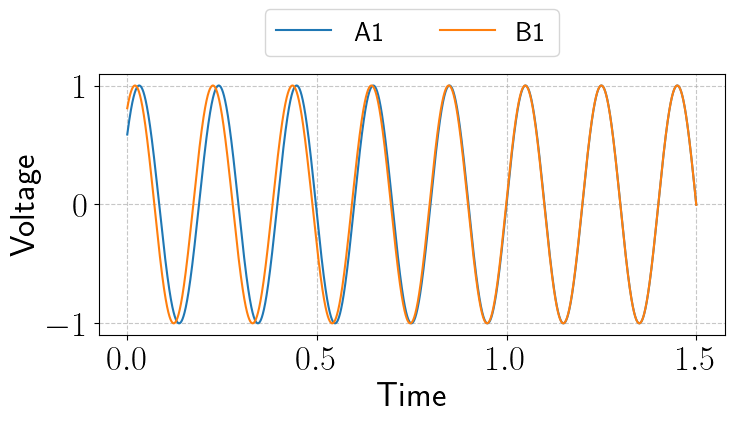

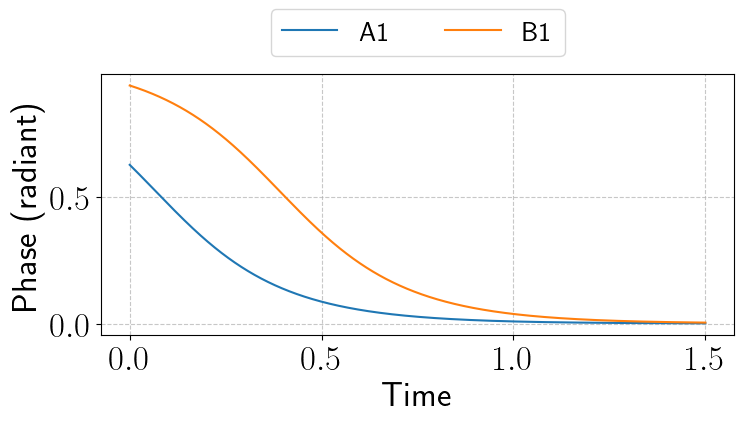

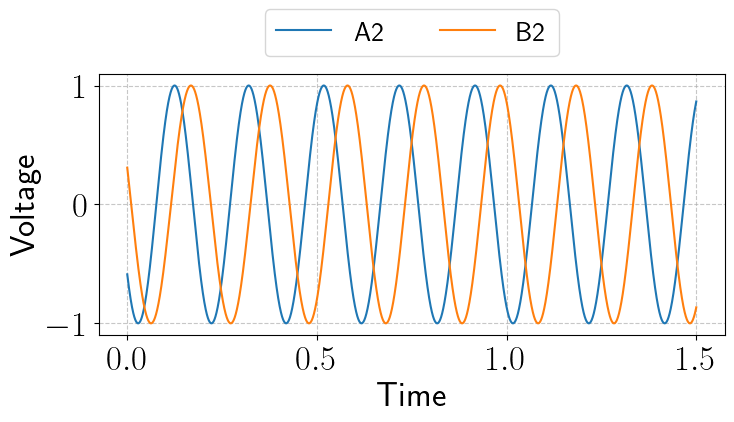

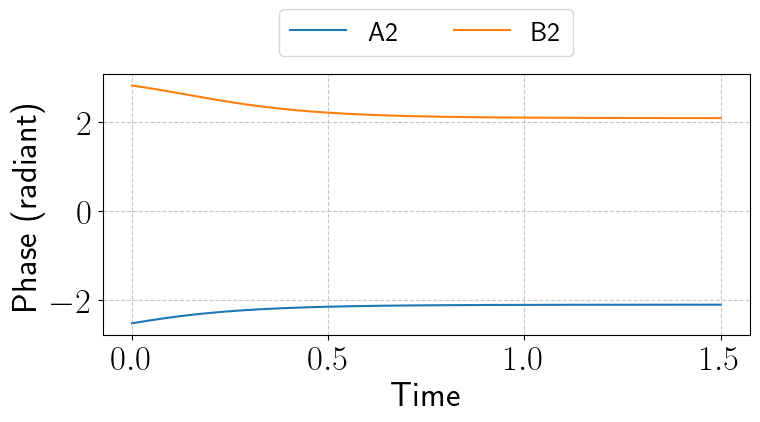

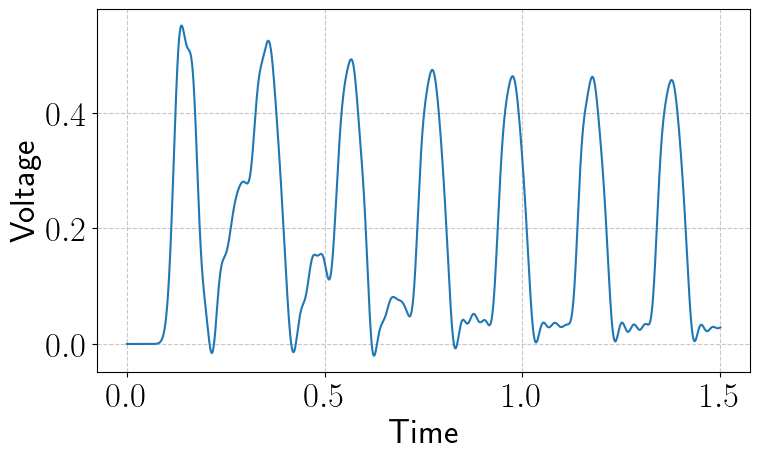

In [98]:
sim_osc_tln(init_phases_normalized=np.array([[0.1, 0.65, -0.8], [-0.9, 0.3, 0.9]]), readout_pos=1, save_file="Example_1")
sim_osc_tln(init_phases_normalized=np.array([[0.1, 0.65, -0.8], [-0.9, 0.3, 0.9]]), readout_pos=2, save_file="Example_2")
sim_osc_tln(init_phases_normalized=np.array([[0.1, 0.2, -0.8], [-0.9, 0.3, 0.9]]), readout_pos=2, save_file="Example_3")

